C:\Users\singhy\AppData\Local\Temp\ipykernel_19500\1591061378.py:85: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  wage_data = wage_data.fillna(1)


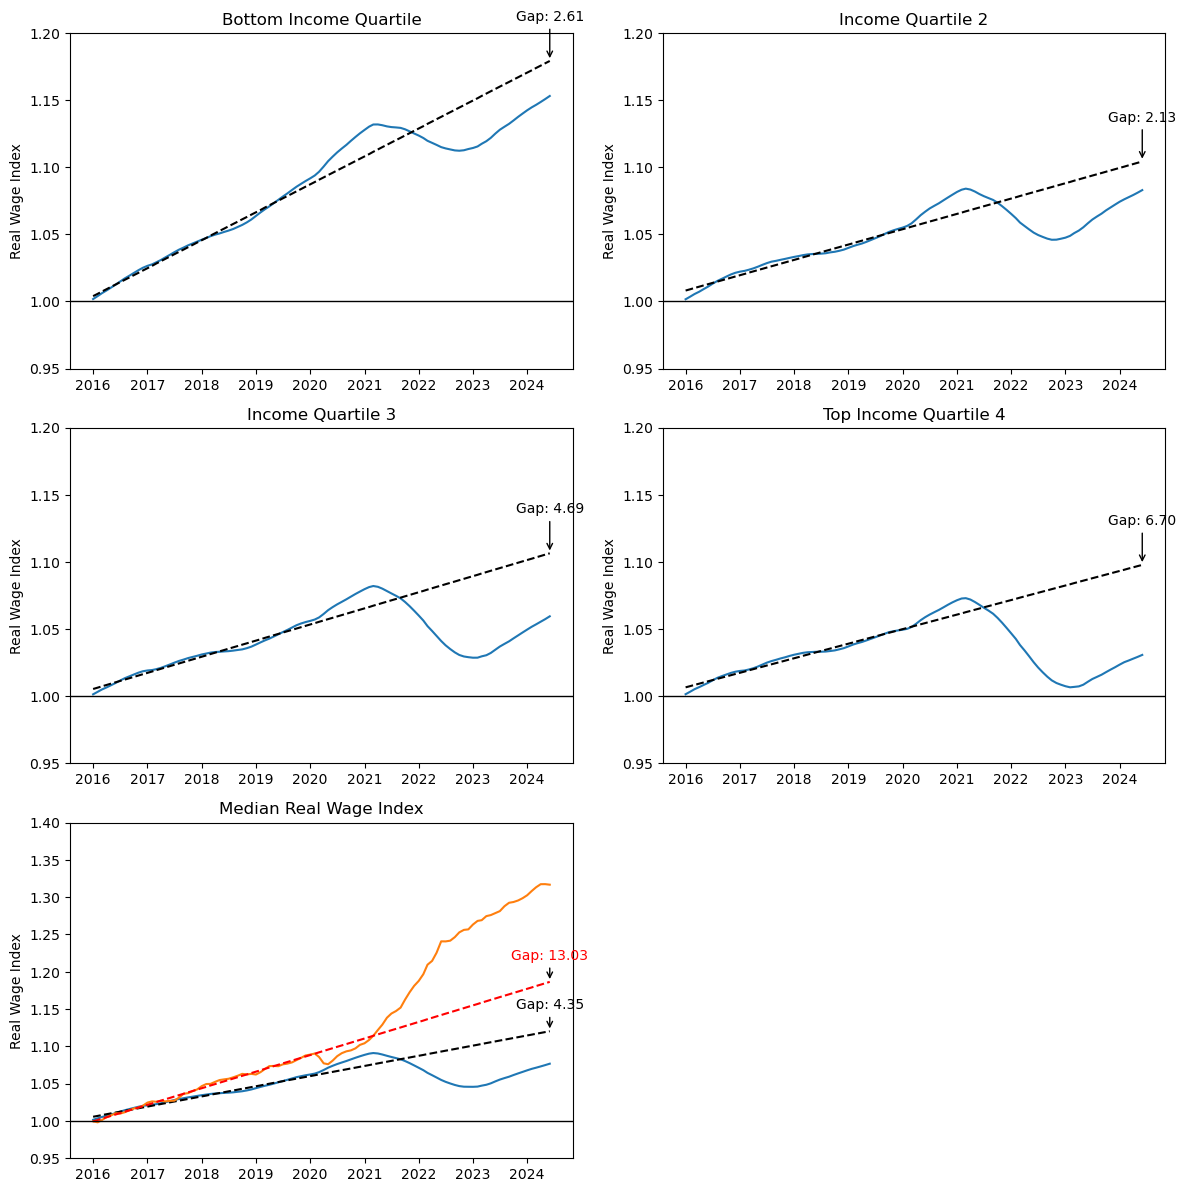

In [6]:
# Yash Singh 
# date: 11/1/2024 
# this script uses data from the Atlanta Fed Wage Tracker to construct real wage indices across the income distribution 

# Specify directories 
data_dir = "C:/Users/singhy/Desktop/Chicago/cps_data/inflation/raw_data"
output_dir = "C:/Users/singhy/Desktop/Chicago/cps_data/inflation/output"


import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

data = pd.read_excel(f"{data_dir}/atl_fed/wage-growth-data.xlsx", sheet_name = 'Average Wage Quartile', skiprows=2, header=0)
cpi = pd.read_excel(f"{data_dir}/CPI/CPIAUCSL.xls", engine='xlrd', header=0)


# Atlanta Fed Wage Data 
data = data.rename(columns={
    'Unnamed: 0': 'date',
    'Lowest quartile of wage distribution': 'Q1',
     '2nd quartile of wage distribution': 'Q2', 
    '3rd quartile of wage distribution': 'Q3', 
    'Highest quartile of wage distribution': 'Q4'
})

select = ['date', 'Q1', 'Q2', 'Q3', 'Q4']
df = data[select]


# CPI-U 
cpi = cpi.iloc[10:].reset_index(drop=True)

cpi = cpi.rename(columns={
                            'FRED Graph Observations': 'date', 
                            'Unnamed: 1':               'P'
})

cpi['date'] = pd.to_datetime(cpi['date'])
cpi['P'] = pd.to_numeric(cpi['P'], errors='coerce')
cpi['P_12m_change'] = cpi['P'].pct_change(periods=12) * 100


wage_data = data.merge(cpi, on='date', how = 'left')

wage_data_copy = wage_data.copy()

#wage_data = wage_data[wage_data['date'] >= '2016-01-01']
wage_data = wage_data[wage_data['date'] >= '2015-12-01']
wage_data = wage_data[wage_data['date'] <= '2024-06-01']


wage_data = wage_data.drop(['Lowest half of wage distribution', 'Upper half of wage distribution'], axis = 1)
wage_data = wage_data.reset_index(drop=True)

wage_data['wage_index_1'] = 1
wage_data['wage_index_2'] = 1
wage_data['wage_index_3'] = 1
wage_data['wage_index_4'] = 1
wage_data['med_wage_index'] = 1 
wage_data['P_norm'] = wage_data['P'] / wage_data['P'].iloc[0]
wage_data['price_mom_grth'] = 1 + wage_data['P_norm'].pct_change()

wage_data = wage_data[wage_data['date'] >= '2016-01-01']

wage_data['q1_mom_grth'] = 1+ (wage_data['Q1']/100)/12
wage_data['q2_mom_grth'] = 1+ (wage_data['Q2']/100)/12
wage_data['q3_mom_grth'] = 1+ (wage_data['Q3']/100)/12
wage_data['q4_mom_grth'] = 1+ (wage_data['Q4']/100)/12
wage_data['med_mom_grth'] = 1+ (wage_data['Overall']/100)/12

wage_data['P_1m_change'] = 1 + (wage_data['P_12m_change']/100)/12

wage_data['nom_wage_index_1'] = wage_data['q1_mom_grth'].cumprod()
wage_data['nom_wage_index_2'] = wage_data['q2_mom_grth'].cumprod()
wage_data['nom_wage_index_3'] = wage_data['q3_mom_grth'].cumprod()
wage_data['nom_wage_index_4'] = wage_data['q4_mom_grth'].cumprod()
wage_data['med_nom_wage_index'] = wage_data['med_mom_grth'].cumprod()
wage_data['price_index']      = wage_data['P_1m_change'].cumprod()
wage_data['cpi']              = wage_data['price_mom_grth'].cumprod()



wage_data = wage_data.fillna(1)

wage_data['real_wage_index_1'] = wage_data['nom_wage_index_1'] / wage_data['price_index']
wage_data['real_wage_index_2'] = wage_data['nom_wage_index_2'] / wage_data['price_index']
wage_data['real_wage_index_3'] = wage_data['nom_wage_index_3'] / wage_data['price_index']
wage_data['real_wage_index_4'] = wage_data['nom_wage_index_4'] / wage_data['price_index']
wage_data['med_real_wage_index'] = wage_data['med_nom_wage_index'] / wage_data['price_index']


# Define the date range for the trend line
start_date = '2016-01-01'
end_date = '2019-12-31'


# Filter the data for the trend calculation
trend_data = wage_data[(wage_data['date'] >= start_date) & (wage_data['date'] <= end_date)]

# Prepare for linear regression with months since the start date
X = ((trend_data['date'].dt.year - trend_data['date'].min().year) * 12 +
     (trend_data['date'].dt.month - trend_data['date'].min().month)).values.reshape(-1, 1)

# Create a dictionary to hold the predicted values for each wage index
predicted_values = {}

# Loop through each wage index to predict values
for column_name in ['real_wage_index_1', 'real_wage_index_2', 'real_wage_index_3', 'real_wage_index_4', 
                    'med_real_wage_index', 'cpi']:
    
    # Fit linear regression model
    y = trend_data[column_name].values
    model = LinearRegression()
    model.fit(X, y)
    
    # Predict for the entire dataset, using months since the start date
    all_dates = ((wage_data['date'].dt.year - trend_data['date'].min().year) * 12 +
                 (wage_data['date'].dt.month - trend_data['date'].min().month)).values.reshape(-1, 1)
    predicted_values[column_name] = model.predict(all_dates)

# Add the predicted columns to the DataFrame
for column_name in predicted_values:
    wage_data[f'predicted_{column_name}'] = predicted_values[column_name]
    


# Assuming wage_data is already defined and includes predicted columns
# Calculate gaps for each index
gaps = {
    'gap_1': wage_data['predicted_real_wage_index_1'].iloc[-1] - wage_data['real_wage_index_1'].iloc[-1],
    'gap_2': wage_data['predicted_real_wage_index_2'].iloc[-1] - wage_data['real_wage_index_2'].iloc[-1],
    'gap_3': wage_data['predicted_real_wage_index_3'].iloc[-1] - wage_data['real_wage_index_3'].iloc[-1],
    'gap_4': wage_data['predicted_real_wage_index_4'].iloc[-1] - wage_data['real_wage_index_4'].iloc[-1],
    'gap_med': wage_data['predicted_med_real_wage_index'].iloc[-1] - wage_data['med_real_wage_index'].iloc[-1],
    'gap_price': wage_data['cpi'].iloc[-1] - wage_data['predicted_cpi'].iloc[-1]
}

# Create five separate plots
plt.figure(figsize=(12, 12))

# Plot for real_wage_index_1
plt.subplot(3, 2, 1)
plt.plot(wage_data['date'], wage_data['real_wage_index_1'], label='Real Wage Index 1')
plt.plot(wage_data['date'], wage_data['predicted_real_wage_index_1'], color='black', linestyle='--', label='Predicted', linewidth=1.5)
plt.title('Bottom Income Quartile')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.2)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=1
plt.annotate(f'Gap: {gaps["gap_1"] * 100:.2f}', 
             xy=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_1'].iloc[-1]), 
             xytext=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_1'].iloc[-1] + 0.03), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), 
             fontsize=10, color='black', ha='center')

# Plot for real_wage_index_2
plt.subplot(3, 2, 2)
plt.plot(wage_data['date'], wage_data['real_wage_index_2'], label='Real Wage Index 2')
plt.plot(wage_data['date'], wage_data['predicted_real_wage_index_2'], color='black', linestyle='--', label='Predicted', linewidth=1.5)
plt.title('Income Quartile 2')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.2)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=1
plt.annotate(f'Gap: {gaps["gap_2"] * 100:.2f}', 
             xy=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_2'].iloc[-1]), 
             xytext=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_2'].iloc[-1] + 0.03), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), 
             fontsize=10, color='black', ha='center')

# Plot for real_wage_index_3
plt.subplot(3, 2, 3)
plt.plot(wage_data['date'], wage_data['real_wage_index_3'], label='Real Wage Index 3')
plt.plot(wage_data['date'], wage_data['predicted_real_wage_index_3'], color='black', linestyle='--', label='Predicted', linewidth=1.5)
plt.title('Income Quartile 3')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.2)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=1
plt.annotate(f'Gap: {gaps["gap_3"] * 100:.2f}', 
             xy=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_3'].iloc[-1]), 
             xytext=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_3'].iloc[-1] + 0.03), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), 
             fontsize=10, color='black', ha='center')

# Plot for real_wage_index_4
plt.subplot(3, 2, 4)
plt.plot(wage_data['date'], wage_data['real_wage_index_4'], label='Real Wage Index 4')
plt.plot(wage_data['date'], wage_data['predicted_real_wage_index_4'], color='black', linestyle='--', label='Predicted', linewidth=1.5)
plt.title('Top Income Quartile 4')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.2)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=1
plt.annotate(f'Gap: {gaps["gap_4"] * 100:.2f}', 
             xy=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_4'].iloc[-1]), 
             xytext=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_4'].iloc[-1] + 0.03), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), 
             fontsize=10, color='black', ha='center')

# Plot for med_real_wage_index
plt.subplot(3, 2, 5)
plt.plot(wage_data['date'], wage_data['med_real_wage_index'])
plt.plot(wage_data['date'], wage_data['predicted_med_real_wage_index'], color='black', linestyle='--', label='Predicted', linewidth=1.5)

plt.plot(wage_data['date'], wage_data['cpi'])
plt.plot(wage_data['date'], wage_data['predicted_cpi'], color='red', linestyle='--', label='Predicted', linewidth=1.5)



plt.title('Median Real Wage Index')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.4)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=1
plt.annotate(f'Gap: {gaps["gap_med"] * 100:.2f}', 
             xy=(wage_data['date'].iloc[-1], wage_data['predicted_med_real_wage_index'].iloc[-1]), 
             xytext=(wage_data['date'].iloc[-1], wage_data['predicted_med_real_wage_index'].iloc[-1] + 0.03), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), 
             fontsize=10, color='black', ha='center')

plt.annotate(f'Gap: {gaps["gap_price"] * 100:.2f}', 
             xy=(wage_data['date'].iloc[-1], wage_data['predicted_cpi'].iloc[-1]), 
             xytext=(wage_data['date'].iloc[-1], wage_data['predicted_cpi'].iloc[-1] + 0.03), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), 
             fontsize=10, color='red', ha='center')

# Adjust layout
plt.tight_layout()  
plt.savefig(f"{output_dir}/figures/wage_index_trends.pdf")
plt.show()

# Export data 
main = ['date', 'cpi', 'predicted_cpi', 
                'med_real_wage_index', 'predicted_med_real_wage_index', 
                'real_wage_index_1', 'predicted_real_wage_index_1', 
                'real_wage_index_2', 'predicted_real_wage_index_2', 
                'real_wage_index_3', 'predicted_real_wage_index_3', 
                'real_wage_index_4', 'predicted_real_wage_index_4']

final = wage_data[main]

final.to_csv(f"{output_dir}/data/real_wage_figures.csv", index = False)

,date,Q1,Q2,Q3,Q4,Overall,Lowest half of wage distribution,Upper half of wage distribution,P,P_12m_change
0,1997-01-01,.,.,.,.,.,.,.,159.400,3.038138
1,1997-02-01,.,.,.,.,.,.,.,159.700,3.032258
2,1997-03-01,.,.,.,.,.,.,.,159.800,2.765273
3,1997-04-01,.,.,.,.,.,.,.,159.900,2.434337
4,1997-05-01,.,.,.,.,.,.,.,159.900,2.237852
...,...,...,...,...,...,...,...,...,...,...
328,2024-05-01,5.5,5.2,5.4,4.8,5.2,5.4,5,313.225,3.250210
329,2024-06-01,5.4,5.1,5.4,4.7,5.1,5.3,5,313.049,2.975629
330,2024-07-01,5.1,5,5.4,4.7,5.1,5.2,5,313.534,2.923566
331,2024-08-01,5.2,4.9,5.2,4.7,5,5.1,4.9,314.121,2.591227
